#### SGD Classifier

In [46]:
%reload_ext autoreload
%autoreload 2

In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict

from src.paths import TRANSFORMED_DATA_DIR
from src.pipeline import get_pipeline
from src.split_and_tfidf import split_and_vect
from src.stemming_and_lemming import stem_reviews

In [52]:
df = pd.read_parquet(TRANSFORMED_DATA_DIR /'cleaned_sentiments.parquet')

In [53]:
df_copy = df.copy()

<Axes: xlabel='recommended'>

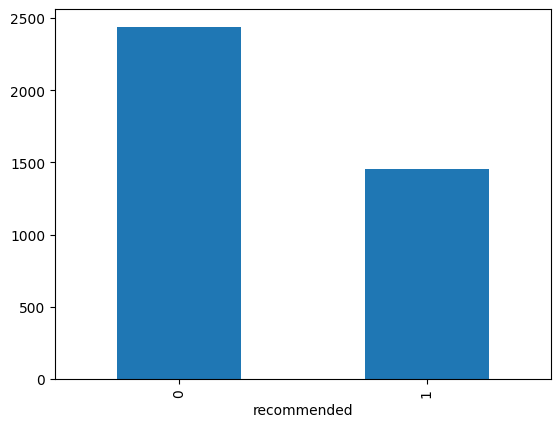

In [54]:
df['recommended'].value_counts().plot(kind='bar')

In [55]:
# split the data and fit a tfidf vectorizer to ita
X_train_vec, X_test_vec, y_train, y_test, tfidf_vec = split_and_vect(df_copy, 'cleaned', 'recommended')

In [59]:
# sgd classifier
sgd = SGDClassifier()

# fit to tfidf vectorizer
sgd.fit(X_train_vec, y_train)

# make predictions
y_pred = cross_val_predict(sgd, X_train_vec, y_train, cv = 5)

In [60]:
# metrics 
report = classification_report(y_train, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1952
           1       0.90      0.80      0.85      1163

    accuracy                           0.89      3115
   macro avg       0.90      0.87      0.88      3115
weighted avg       0.89      0.89      0.89      3115



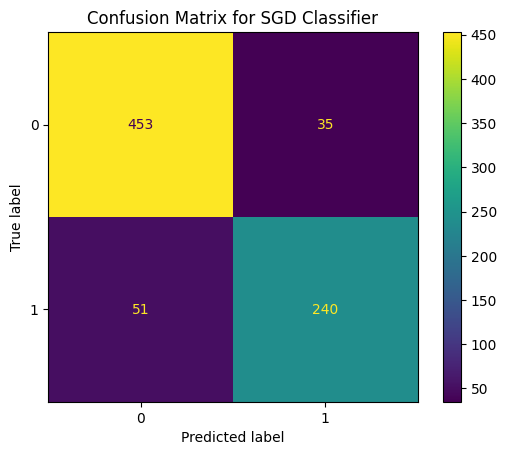

In [61]:
ConfusionMatrixDisplay.from_estimator(sgd, X_test_vec, y_test)
plt.title('Confusion Matrix for SGD Classifier')
plt.show()

In [62]:
# stemming
df_stem = df.copy()

# perform stemming on the data
df_stem['stemmed'] = stem_reviews(df_stem['cleaned'])

In [63]:
df_stem.tail()

,recommended,cleaned,stemmed
3887,0,Business LHR to BKK 747 400 First try back wit...,busi lhr to bkk 747 400 first tri back with ba...
3890,1,LHR to HAM Purser addresses all club passenger...,lhr to ham purser address all club passeng by ...
3891,0,My son who had worked for British Airways urge...,my son who had work for british airway urg me ...
3892,0,London City New York JFK via Shannon on A318 b...,london citi new york jfk via shannon on a318 b...
3893,0,SIN LHR BA12 B747 436 First Class Old aircraft...,sin lhr ba12 b747 436 first class old aircraft...


In [66]:
# split and vectorize
X_train_stem, X_test_stem, y_train, y_test, tfidf_stem_vec = split_and_vect(df_stem, 'stemmed', 'recommended')

# fit stemmed to sgd
# instantiate
sgd_stem = SGDClassifier()

# fit to the data
sgd_stem.fit(X_train_stem, y_train)

# make predictions
y_pred_stem = cross_val_predict(sgd_stem, X_train_stem, y_train, cv=5)


In [68]:
# metrics
print(classification_report(y_train, y_pred_stem))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1952
           1       0.90      0.81      0.85      1163

    accuracy                           0.90      3115
   macro avg       0.90      0.88      0.89      3115
weighted avg       0.90      0.90      0.90      3115



Text(0.5, 1.0, 'Confusion Matrix for SGD Classifier with Stemming')

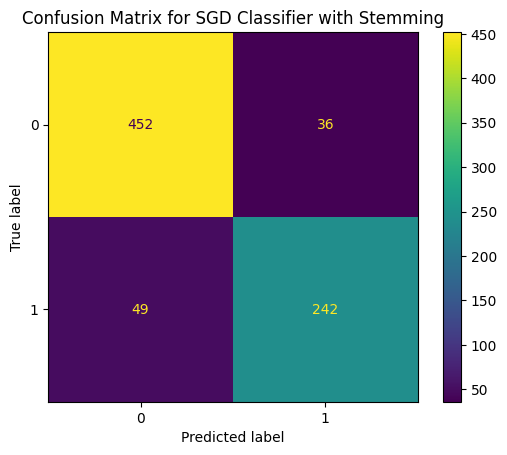

In [69]:
# confusion matrix
ConfusionMatrixDisplay.from_estimator(sgd_stem, X_test_stem, y_test)
plt.title('Confusion Matrix for SGD Classifier with Stemming')

#### Lemmatizing

In [70]:
# make a copy of the data
df_lemm = df.copy()

# lemmatize
from src.stemming_and_lemming import get_wordnet_pos, lemmatize_reviews

df_lemm['lemmatized'] = lemmatize_reviews(df['cleaned'])
df_lemm.head()

,recommended,cleaned,lemmatized
0,1,Very good flight following an equally good fli...,Very good flight follow an equally good flight...
1,1,An hours delay due to late arrival of the inco...,An hour delay due to late arrival of the incom...
2,0,I booked through BA because Loganair dont have...,I book through BA because Loganair dont have r...
3,0,British airways lost bags in LHR then found th...,British airway lose bag in LHR then find them ...
4,0,The check in process and reward loyalty progra...,The check in process and reward loyalty progra...


In [72]:
# split lemmatized data
X_train_lem, X_test_lem, y_train, y_test, tfidf_lem = split_and_vect(df_lemm, 'lemmatized', 'recommended')

# sgd classifier
sgd_lem = SGDClassifier()

# fit
sgd_lem.fit(X_train_lem, y_train)

# predict
y_pred_lem = cross_val_predict(sgd_lem, X_train_lem, y_train, cv = 5)

# classification report
print(classification_report(y_train, y_pred_lem))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1952
           1       0.80      0.67      0.73      1163

    accuracy                           0.82      3115
   macro avg       0.81      0.79      0.80      3115
weighted avg       0.81      0.82      0.81      3115



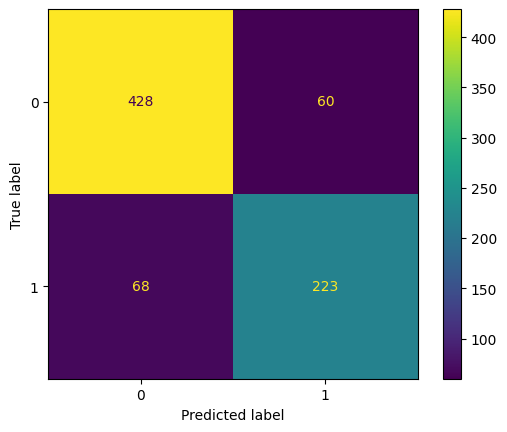

In [73]:
ConfusionMatrixDisplay.from_estimator(sgd_lem, X_test_lem, y_test)

### Hyperparameter Tuning with Optuna

In [75]:
import optuna
from sklearn.model_selection import cross_val_score

In [76]:
# create the optuna trial
def objective(trial: optuna.trial.Trial) -> float:
    '''Optuna Optimization Objective. Given the set of hyperparameters it will train a 
    model and return the average score based on cross-validation.'''
    # hyperparams
    hyperparams = {
        'loss': trial.suggest_categorical('loss', ['hinge', 'log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
        'alpha': trial.suggest_float('alpha', 1e-4, 1e-2),
        'max_iter': trial.suggest_int('max_iter', 1000, 5000),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1),
        'power_t': trial.suggest_float('power_t', 0.25, 0.75)
    }

    # create the model
    sgd_model = SGDClassifier(**hyperparams)

    # cross-val
    cross_val = cross_val_score(sgd_model, X_train_stem, y_train, cv = 3, scoring= 'accuracy')

    return cross_val.mean()


In [77]:
# run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-02-03 14:44:03,914] A new study created in memory with name: no-name-55a99770-d169-46a2-ab54-50c9a8a905ae
[I 2025-02-03 14:44:04,006] Trial 0 finished with value: 0.6266452909428871 and parameters: {'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.007093412313325281, 'max_iter': 2756, 'learning_rate': 'invscaling', 'eta0': 0.03139855566966111, 'power_t': 0.6843387146180243}. Best is trial 0 with value: 0.6266452909428871.
[I 2025-02-03 14:44:04,354] Trial 1 finished with value: 0.7878020526381834 and parameters: {'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.00437311363878304, 'max_iter': 2686, 'learning_rate': 'adaptive', 'eta0': 0.08759617662174304, 'power_t': 0.7322894315320647}. Best is trial 1 with value: 0.7878020526381834.
[I 2025-02-03 14:44:04,396] Trial 2 finished with value: 0.6266452909428871 and parameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.009057575224258589, 'max_iter': 3732, 'learning_rate': 'optimal', 'eta0': 0.08580532778663595, 'pow

In [78]:
# best params
best_params = study.best_params
print(f'{best_params=}')

best_params={'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00019489982799319149, 'max_iter': 1029, 'learning_rate': 'optimal', 'eta0': 0.06205801794966808, 'power_t': 0.26202060591968174}


In [79]:
# fit model with new hyperparams
model_2 = SGDClassifier(**best_params)

model_2.fit(X_train_stem, y_train)

y_pred = model_2.predict(X_test_stem)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       488
           1       0.86      0.81      0.84       291

    accuracy                           0.88       779
   macro avg       0.88      0.87      0.87       779
weighted avg       0.88      0.88      0.88       779



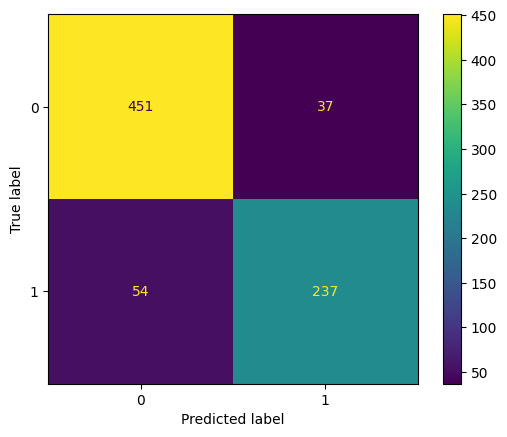

In [80]:
ConfusionMatrixDisplay.from_estimator(model_2, X_test_stem, y_test)

#### Adding Feature Selection Using Chi2

In [83]:
import optuna
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Objective function for Optuna
def objective(trial):
    # Suggest a value for the percentile
    percentile = trial.suggest_int('percentile', 10, 75)
    
    # Define hyperparameters in a dictionary
    hyperparams = {
        'loss': trial.suggest_categorical('loss', ['hinge', 'log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
        'alpha': trial.suggest_float('alpha', 1e-4, 1e-2),
        'max_iter': trial.suggest_int('max_iter', 1000, 5000),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1),
        'power_t': trial.suggest_float('power_t', 0.25, 0.75)
    }
    
    # Combine the percentile with hyperparameters
    best_params = {'percentile': percentile, **hyperparams}
    
    # Create the pipeline
    pipeline = get_pipeline(**best_params)
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X_train_stem, y_train, cv=3, scoring='accuracy')
    
    # Return the average accuracy
    return scores.mean()

# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Output the best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

# Create the pipeline with the best hyperparameters
pipeline = get_pipeline(**best_params)

# Fit the pipeline to the training data
pipeline.fit(X_train_stem, y_train)

# Make predictions and evaluate the model (optional)
predictions = pipeline.predict(X_test_stem)
print(classification_report(y_test, predictions))


[I 2025-02-03 14:55:23,869] A new study created in memory with name: no-name-056f90a2-ef25-4a44-b0c1-56eae0019fc9


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.007522103503748365, 'max_iter': 3080, 'learning_rate': 'constant', 'eta0': 0.08290457200578853, 'power_t': 0.6568329741548491}
Selecting best 30 percent of features.
Pipeline created.


[I 2025-02-03 14:55:25,236] Trial 0 finished with value: 0.7354738728447331 and parameters: {'percentile': 30, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.007522103503748365, 'max_iter': 3080, 'learning_rate': 'constant', 'eta0': 0.08290457200578853, 'power_t': 0.6568329741548491}. Best is trial 0 with value: 0.7354738728447331.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.007565947412640958, 'max_iter': 2450, 'learning_rate': 'constant', 'eta0': 0.007153698917583737, 'power_t': 0.7330863142024948}
Selecting best 45 percent of features.
Pipeline created.


[I 2025-02-03 14:55:26,415] Trial 1 finished with value: 0.6272875517007547 and parameters: {'percentile': 45, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.007565947412640958, 'max_iter': 2450, 'learning_rate': 'constant', 'eta0': 0.007153698917583737, 'power_t': 0.7330863142024948}. Best is trial 0 with value: 0.7354738728447331.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.003768789552717784, 'max_iter': 1413, 'learning_rate': 'invscaling', 'eta0': 0.06967585938917673, 'power_t': 0.7217523860970299}
Selecting best 73 percent of features.
Pipeline created.


[I 2025-02-03 14:55:27,743] Trial 2 finished with value: 0.6266452909428871 and parameters: {'percentile': 73, 'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.003768789552717784, 'max_iter': 1413, 'learning_rate': 'invscaling', 'eta0': 0.06967585938917673, 'power_t': 0.7217523860970299}. Best is trial 0 with value: 0.7354738728447331.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00255458008154144, 'max_iter': 3976, 'learning_rate': 'invscaling', 'eta0': 0.004336124041427003, 'power_t': 0.5884643079669925}
Selecting best 65 percent of features.
Pipeline created.


[I 2025-02-03 14:55:29,009] Trial 3 finished with value: 0.6266452909428871 and parameters: {'percentile': 65, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00255458008154144, 'max_iter': 3976, 'learning_rate': 'invscaling', 'eta0': 0.004336124041427003, 'power_t': 0.5884643079669925}. Best is trial 0 with value: 0.7354738728447331.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.007551066302134527, 'max_iter': 4690, 'learning_rate': 'invscaling', 'eta0': 0.09151373226194905, 'power_t': 0.5630319829559327}
Selecting best 57 percent of features.
Pipeline created.


[I 2025-02-03 14:55:30,305] Trial 4 finished with value: 0.6266452909428871 and parameters: {'percentile': 57, 'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.007551066302134527, 'max_iter': 4690, 'learning_rate': 'invscaling', 'eta0': 0.09151373226194905, 'power_t': 0.5630319829559327}. Best is trial 0 with value: 0.7354738728447331.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0008985795069705462, 'max_iter': 2403, 'learning_rate': 'invscaling', 'eta0': 0.09552593914905211, 'power_t': 0.3839939435250909}
Selecting best 56 percent of features.
Pipeline created.


[I 2025-02-03 14:55:32,156] Trial 5 finished with value: 0.8619655528171387 and parameters: {'percentile': 56, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0008985795069705462, 'max_iter': 2403, 'learning_rate': 'invscaling', 'eta0': 0.09552593914905211, 'power_t': 0.3839939435250909}. Best is trial 5 with value: 0.8619655528171387.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.004777814535827841, 'max_iter': 3500, 'learning_rate': 'adaptive', 'eta0': 0.008318444496644446, 'power_t': 0.584132402551795}
Selecting best 71 percent of features.
Pipeline created.


[I 2025-02-03 14:55:33,886] Trial 6 finished with value: 0.6266452909428871 and parameters: {'percentile': 71, 'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.004777814535827841, 'max_iter': 3500, 'learning_rate': 'adaptive', 'eta0': 0.008318444496644446, 'power_t': 0.584132402551795}. Best is trial 5 with value: 0.8619655528171387.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.004644686552000738, 'max_iter': 3146, 'learning_rate': 'adaptive', 'eta0': 0.04334995151024214, 'power_t': 0.42366921705808447}
Selecting best 61 percent of features.
Pipeline created.


[I 2025-02-03 14:55:35,253] Trial 7 finished with value: 0.6321026529263662 and parameters: {'percentile': 61, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.004644686552000738, 'max_iter': 3146, 'learning_rate': 'adaptive', 'eta0': 0.04334995151024214, 'power_t': 0.42366921705808447}. Best is trial 5 with value: 0.8619655528171387.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.005693172157977843, 'max_iter': 3402, 'learning_rate': 'constant', 'eta0': 0.0665427148887072, 'power_t': 0.4688521468407311}
Selecting best 18 percent of features.
Pipeline created.


[I 2025-02-03 14:55:36,635] Trial 8 finished with value: 0.6266452909428871 and parameters: {'percentile': 18, 'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.005693172157977843, 'max_iter': 3402, 'learning_rate': 'constant', 'eta0': 0.0665427148887072, 'power_t': 0.4688521468407311}. Best is trial 5 with value: 0.8619655528171387.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.009092457364515588, 'max_iter': 2183, 'learning_rate': 'optimal', 'eta0': 0.048372433301579205, 'power_t': 0.29733515210158545}
Selecting best 29 percent of features.
Pipeline created.


[I 2025-02-03 14:55:37,939] Trial 9 finished with value: 0.6266452909428871 and parameters: {'percentile': 29, 'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.009092457364515588, 'max_iter': 2183, 'learning_rate': 'optimal', 'eta0': 0.048372433301579205, 'power_t': 0.29733515210158545}. Best is trial 5 with value: 0.8619655528171387.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00022184409507925926, 'max_iter': 1820, 'learning_rate': 'optimal', 'eta0': 0.09879324400012834, 'power_t': 0.2637242084913145}
Selecting best 48 percent of features.
Pipeline created.


[I 2025-02-03 14:55:39,268] Trial 10 finished with value: 0.8931022183649487 and parameters: {'percentile': 48, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00022184409507925926, 'max_iter': 1820, 'learning_rate': 'optimal', 'eta0': 0.09879324400012834, 'power_t': 0.2637242084913145}. Best is trial 10 with value: 0.8931022183649487.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00035627836429942723, 'max_iter': 1087, 'learning_rate': 'optimal', 'eta0': 0.09937379291334497, 'power_t': 0.2581046814180928}
Selecting best 49 percent of features.
Pipeline created.


[I 2025-02-03 14:55:40,689] Trial 11 finished with value: 0.8937447881992157 and parameters: {'percentile': 49, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00035627836429942723, 'max_iter': 1087, 'learning_rate': 'optimal', 'eta0': 0.09937379291334497, 'power_t': 0.2581046814180928}. Best is trial 11 with value: 0.8937447881992157.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00037551853105394374, 'max_iter': 1048, 'learning_rate': 'optimal', 'eta0': 0.07700594993957287, 'power_t': 0.2594511023420373}
Selecting best 44 percent of features.
Pipeline created.


[I 2025-02-03 14:55:41,989] Trial 12 finished with value: 0.8914971846230783 and parameters: {'percentile': 44, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00037551853105394374, 'max_iter': 1048, 'learning_rate': 'optimal', 'eta0': 0.07700594993957287, 'power_t': 0.2594511023420373}. Best is trial 11 with value: 0.8937447881992157.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0019356941754397864, 'max_iter': 1647, 'learning_rate': 'optimal', 'eta0': 0.09784928485442848, 'power_t': 0.3330667573155765}
Selecting best 48 percent of features.
Pipeline created.


[I 2025-02-03 14:55:43,386] Trial 13 finished with value: 0.8664589055110176 and parameters: {'percentile': 48, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0019356941754397864, 'max_iter': 1647, 'learning_rate': 'optimal', 'eta0': 0.09784928485442848, 'power_t': 0.3330667573155765}. Best is trial 11 with value: 0.8937447881992157.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00012725715264929954, 'max_iter': 1825, 'learning_rate': 'optimal', 'eta0': 0.06177132502986631, 'power_t': 0.2514430977428522}
Selecting best 35 percent of features.
Pipeline created.


[I 2025-02-03 14:55:44,748] Trial 14 finished with value: 0.8927801607568169 and parameters: {'percentile': 35, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00012725715264929954, 'max_iter': 1825, 'learning_rate': 'optimal', 'eta0': 0.06177132502986631, 'power_t': 0.2514430977428522}. Best is trial 11 with value: 0.8937447881992157.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.0022828668420871367, 'max_iter': 1085, 'learning_rate': 'optimal', 'eta0': 0.03042710193222044, 'power_t': 0.34568801535916904}
Selecting best 50 percent of features.
Pipeline created.


[I 2025-02-03 14:55:46,077] Trial 15 finished with value: 0.8240795859365293 and parameters: {'percentile': 50, 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.0022828668420871367, 'max_iter': 1085, 'learning_rate': 'optimal', 'eta0': 0.03042710193222044, 'power_t': 0.34568801535916904}. Best is trial 11 with value: 0.8937447881992157.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0012780221398332055, 'max_iter': 1873, 'learning_rate': 'optimal', 'eta0': 0.08477792547295133, 'power_t': 0.4355453909475786}
Selecting best 37 percent of features.
Pipeline created.


[I 2025-02-03 14:55:47,391] Trial 16 finished with value: 0.8773739385543755 and parameters: {'percentile': 37, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0012780221398332055, 'max_iter': 1873, 'learning_rate': 'optimal', 'eta0': 0.08477792547295133, 'power_t': 0.4355453909475786}. Best is trial 11 with value: 0.8937447881992157.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0031267147508660274, 'max_iter': 2665, 'learning_rate': 'optimal', 'eta0': 0.0990690779414706, 'power_t': 0.5182901801553241}
Selecting best 16 percent of features.
Pipeline created.


[I 2025-02-03 14:55:48,724] Trial 17 finished with value: 0.8407762021062939 and parameters: {'percentile': 16, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0031267147508660274, 'max_iter': 2665, 'learning_rate': 'optimal', 'eta0': 0.0990690779414706, 'power_t': 0.5182901801553241}. Best is trial 11 with value: 0.8937447881992157.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0013825921934936419, 'max_iter': 1301, 'learning_rate': 'optimal', 'eta0': 0.02831431646926646, 'power_t': 0.36300094760584056}
Selecting best 55 percent of features.
Pipeline created.


[I 2025-02-03 14:55:50,066] Trial 18 finished with value: 0.8776972324681048 and parameters: {'percentile': 55, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0013825921934936419, 'max_iter': 1301, 'learning_rate': 'optimal', 'eta0': 0.02831431646926646, 'power_t': 0.36300094760584056}. Best is trial 11 with value: 0.8937447881992157.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.0039042411789395434, 'max_iter': 1999, 'learning_rate': 'adaptive', 'eta0': 0.07741028058499527, 'power_t': 0.3031963279911809}
Selecting best 40 percent of features.
Pipeline created.


[I 2025-02-03 14:55:51,583] Trial 19 finished with value: 0.7967906124843376 and parameters: {'percentile': 40, 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.0039042411789395434, 'max_iter': 1999, 'learning_rate': 'adaptive', 'eta0': 0.07741028058499527, 'power_t': 0.3031963279911809}. Best is trial 11 with value: 0.8937447881992157.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.005922619881439536, 'max_iter': 4958, 'learning_rate': 'optimal', 'eta0': 0.05878184995601775, 'power_t': 0.4028255256398382}
Selecting best 24 percent of features.
Pipeline created.


[I 2025-02-03 14:55:52,961] Trial 20 finished with value: 0.6266452909428871 and parameters: {'percentile': 24, 'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.005922619881439536, 'max_iter': 4958, 'learning_rate': 'optimal', 'eta0': 0.05878184995601775, 'power_t': 0.4028255256398382}. Best is trial 11 with value: 0.8937447881992157.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00015456475453081396, 'max_iter': 1647, 'learning_rate': 'optimal', 'eta0': 0.08874045518126257, 'power_t': 0.2508033492958934}
Selecting best 35 percent of features.
Pipeline created.


[I 2025-02-03 14:55:54,339] Trial 21 finished with value: 0.8943864308042847 and parameters: {'percentile': 35, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00015456475453081396, 'max_iter': 1647, 'learning_rate': 'optimal', 'eta0': 0.08874045518126257, 'power_t': 0.2508033492958934}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00021973594126195687, 'max_iter': 1525, 'learning_rate': 'optimal', 'eta0': 0.08632804960712567, 'power_t': 0.28466770154195686}
Selecting best 33 percent of features.
Pipeline created.


[I 2025-02-03 14:55:55,745] Trial 22 finished with value: 0.894065300425351 and parameters: {'percentile': 33, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00021973594126195687, 'max_iter': 1525, 'learning_rate': 'optimal', 'eta0': 0.08632804960712567, 'power_t': 0.28466770154195686}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0014540432598562202, 'max_iter': 1486, 'learning_rate': 'optimal', 'eta0': 0.08645083043113665, 'power_t': 0.32322772533514993}
Selecting best 32 percent of features.
Pipeline created.


[I 2025-02-03 14:55:57,067] Trial 23 finished with value: 0.8735231556947637 and parameters: {'percentile': 32, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0014540432598562202, 'max_iter': 1486, 'learning_rate': 'optimal', 'eta0': 0.08645083043113665, 'power_t': 0.32322772533514993}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0007648616465088765, 'max_iter': 1316, 'learning_rate': 'optimal', 'eta0': 0.07481151097491513, 'power_t': 0.29008655029485636}
Selecting best 40 percent of features.
Pipeline created.


[I 2025-02-03 14:55:58,406] Trial 24 finished with value: 0.8889281415916074 and parameters: {'percentile': 40, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0007648616465088765, 'max_iter': 1316, 'learning_rate': 'optimal', 'eta0': 0.07481151097491513, 'power_t': 0.29008655029485636}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0019509321961771004, 'max_iter': 1039, 'learning_rate': 'optimal', 'eta0': 0.08889326176168698, 'power_t': 0.36400340872215686}
Selecting best 10 percent of features.
Pipeline created.


[I 2025-02-03 14:55:59,910] Trial 25 finished with value: 0.8664589055110176 and parameters: {'percentile': 10, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0019509321961771004, 'max_iter': 1039, 'learning_rate': 'optimal', 'eta0': 0.08889326176168698, 'power_t': 0.36400340872215686}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.002963901241137644, 'max_iter': 2618, 'learning_rate': 'optimal', 'eta0': 0.08108818882131116, 'power_t': 0.2865931128034501}
Selecting best 25 percent of features.
Pipeline created.


[I 2025-02-03 14:56:01,283] Trial 26 finished with value: 0.8475180856055085 and parameters: {'percentile': 25, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.002963901241137644, 'max_iter': 2618, 'learning_rate': 'optimal', 'eta0': 0.08108818882131116, 'power_t': 0.2865931128034501}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0010360692598590123, 'max_iter': 2187, 'learning_rate': 'adaptive', 'eta0': 0.09094237830659824, 'power_t': 0.3222372833859277}
Selecting best 36 percent of features.
Pipeline created.


[I 2025-02-03 14:56:03,031] Trial 27 finished with value: 0.88154646994572 and parameters: {'percentile': 36, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0010360692598590123, 'max_iter': 2187, 'learning_rate': 'adaptive', 'eta0': 0.09094237830659824, 'power_t': 0.3222372833859277}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.00016442785222178623, 'max_iter': 1545, 'learning_rate': 'constant', 'eta0': 0.05666419797299847, 'power_t': 0.4728809381332201}
Selecting best 25 percent of features.
Pipeline created.


[I 2025-02-03 14:56:04,446] Trial 28 finished with value: 0.8635718228646067 and parameters: {'percentile': 25, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.00016442785222178623, 'max_iter': 1545, 'learning_rate': 'constant', 'eta0': 0.05666419797299847, 'power_t': 0.4728809381332201}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.0017878740085773162, 'max_iter': 2807, 'learning_rate': 'constant', 'eta0': 0.06999661424075936, 'power_t': 0.6827253665749424}
Selecting best 31 percent of features.
Pipeline created.


[I 2025-02-03 14:56:05,848] Trial 29 finished with value: 0.8333905124672146 and parameters: {'percentile': 31, 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.0017878740085773162, 'max_iter': 2807, 'learning_rate': 'constant', 'eta0': 0.06999661424075936, 'power_t': 0.6827253665749424}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.009359633462972788, 'max_iter': 2162, 'learning_rate': 'optimal', 'eta0': 0.08227598603512672, 'power_t': 0.252452080958892}
Selecting best 52 percent of features.
Pipeline created.


[I 2025-02-03 14:56:07,188] Trial 30 finished with value: 0.7149292555029506 and parameters: {'percentile': 52, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.009359633462972788, 'max_iter': 2162, 'learning_rate': 'optimal', 'eta0': 0.08227598603512672, 'power_t': 0.252452080958892}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0006332187159963851, 'max_iter': 1732, 'learning_rate': 'optimal', 'eta0': 0.0979763642612049, 'power_t': 0.2761709995668702}
Selecting best 47 percent of features.
Pipeline created.


[I 2025-02-03 14:56:08,618] Trial 31 finished with value: 0.89310160021215 and parameters: {'percentile': 47, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0006332187159963851, 'max_iter': 1732, 'learning_rate': 'optimal', 'eta0': 0.0979763642612049, 'power_t': 0.2761709995668702}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00011771913486169069, 'max_iter': 1283, 'learning_rate': 'optimal', 'eta0': 0.091878923712381, 'power_t': 0.3141055781154851}
Selecting best 42 percent of features.
Pipeline created.


[I 2025-02-03 14:56:09,979] Trial 32 finished with value: 0.8902138994129403 and parameters: {'percentile': 42, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00011771913486169069, 'max_iter': 1283, 'learning_rate': 'optimal', 'eta0': 0.091878923712381, 'power_t': 0.3141055781154851}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0009005699047824212, 'max_iter': 1547, 'learning_rate': 'optimal', 'eta0': 0.08551474903008988, 'power_t': 0.2501908929113076}
Selecting best 44 percent of features.
Pipeline created.


[I 2025-02-03 14:56:11,368] Trial 33 finished with value: 0.8870025956236018 and parameters: {'percentile': 44, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0009005699047824212, 'max_iter': 1547, 'learning_rate': 'optimal', 'eta0': 0.08551474903008988, 'power_t': 0.2501908929113076}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.002845915931822413, 'max_iter': 1948, 'learning_rate': 'optimal', 'eta0': 0.09379519097135494, 'power_t': 0.28150863168064055}
Selecting best 37 percent of features.
Pipeline created.


[I 2025-02-03 14:56:12,751] Trial 34 finished with value: 0.8513694866179192 and parameters: {'percentile': 37, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.002845915931822413, 'max_iter': 1948, 'learning_rate': 'optimal', 'eta0': 0.09379519097135494, 'power_t': 0.28150863168064055}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.006751227456827663, 'max_iter': 1247, 'learning_rate': 'invscaling', 'eta0': 0.0995298632126964, 'power_t': 0.35315399532917513}
Selecting best 65 percent of features.
Pipeline created.


[I 2025-02-03 14:56:14,135] Trial 35 finished with value: 0.6266452909428871 and parameters: {'percentile': 65, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.006751227456827663, 'max_iter': 1247, 'learning_rate': 'invscaling', 'eta0': 0.0995298632126964, 'power_t': 0.35315399532917513}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.003798560721525241, 'max_iter': 2384, 'learning_rate': 'constant', 'eta0': 0.07342205523746961, 'power_t': 0.38886098031169924}
Selecting best 52 percent of features.
Pipeline created.


[I 2025-02-03 14:56:15,575] Trial 36 finished with value: 0.7987173947579406 and parameters: {'percentile': 52, 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.003798560721525241, 'max_iter': 2384, 'learning_rate': 'constant', 'eta0': 0.07342205523746961, 'power_t': 0.38886098031169924}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.00827534194307037, 'max_iter': 4169, 'learning_rate': 'optimal', 'eta0': 0.08038006226526934, 'power_t': 0.642924941119347}
Selecting best 60 percent of features.
Pipeline created.


[I 2025-02-03 14:56:16,896] Trial 37 finished with value: 0.6266452909428871 and parameters: {'percentile': 60, 'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.00827534194307037, 'max_iter': 4169, 'learning_rate': 'optimal', 'eta0': 0.08038006226526934, 'power_t': 0.642924941119347}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.002282934067496249, 'max_iter': 1661, 'learning_rate': 'invscaling', 'eta0': 0.08953750279920006, 'power_t': 0.2756491228276427}
Selecting best 29 percent of features.
Pipeline created.


[I 2025-02-03 14:56:18,490] Trial 38 finished with value: 0.6378802180595814 and parameters: {'percentile': 29, 'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.002282934067496249, 'max_iter': 1661, 'learning_rate': 'invscaling', 'eta0': 0.08953750279920006, 'power_t': 0.2756491228276427}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0007038842908825298, 'max_iter': 1003, 'learning_rate': 'adaptive', 'eta0': 0.09437213626387042, 'power_t': 0.5295635369433878}
Selecting best 47 percent of features.
Pipeline created.


[I 2025-02-03 14:56:19,842] Trial 39 finished with value: 0.8860410589451965 and parameters: {'percentile': 47, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0007038842908825298, 'max_iter': 1003, 'learning_rate': 'adaptive', 'eta0': 0.09437213626387042, 'power_t': 0.5295635369433878}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.0015303433694693364, 'max_iter': 2983, 'learning_rate': 'invscaling', 'eta0': 0.03415645003529628, 'power_t': 0.3057059677802394}
Selecting best 66 percent of features.
Pipeline created.


[I 2025-02-03 14:56:21,583] Trial 40 finished with value: 0.6269664213218209 and parameters: {'percentile': 66, 'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.0015303433694693364, 'max_iter': 2983, 'learning_rate': 'invscaling', 'eta0': 0.03415645003529628, 'power_t': 0.3057059677802394}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0006555780797160427, 'max_iter': 1762, 'learning_rate': 'optimal', 'eta0': 0.09984997127298012, 'power_t': 0.2790085222995198}
Selecting best 47 percent of features.
Pipeline created.


[I 2025-02-03 14:56:23,027] Trial 41 finished with value: 0.8921385181517478 and parameters: {'percentile': 47, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0006555780797160427, 'max_iter': 1762, 'learning_rate': 'optimal', 'eta0': 0.09984997127298012, 'power_t': 0.2790085222995198}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005082338164433494, 'max_iter': 1432, 'learning_rate': 'optimal', 'eta0': 0.09414001110504716, 'power_t': 0.2734177165572237}
Selecting best 41 percent of features.
Pipeline created.


[I 2025-02-03 14:56:24,370] Trial 42 finished with value: 0.8934233487438826 and parameters: {'percentile': 41, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005082338164433494, 'max_iter': 1432, 'learning_rate': 'optimal', 'eta0': 0.09414001110504716, 'power_t': 0.2734177165572237}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0012406108943663144, 'max_iter': 2063, 'learning_rate': 'optimal', 'eta0': 0.09399551462785966, 'power_t': 0.33216864373048677}
Selecting best 40 percent of features.
Pipeline created.


[I 2025-02-03 14:56:25,703] Trial 43 finished with value: 0.8789786632198466 and parameters: {'percentile': 40, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0012406108943663144, 'max_iter': 2063, 'learning_rate': 'optimal', 'eta0': 0.09399551462785966, 'power_t': 0.33216864373048677}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00012597806276644304, 'max_iter': 1401, 'learning_rate': 'optimal', 'eta0': 0.014267234732636982, 'power_t': 0.2723677341610908}
Selecting best 33 percent of features.
Pipeline created.


[I 2025-02-03 14:56:27,099] Trial 44 finished with value: 0.8934227305910839 and parameters: {'percentile': 33, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00012597806276644304, 'max_iter': 1401, 'learning_rate': 'optimal', 'eta0': 0.014267234732636982, 'power_t': 0.2723677341610908}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00045298518598750707, 'max_iter': 1483, 'learning_rate': 'optimal', 'eta0': 0.006088979089075887, 'power_t': 0.30712649083686994}
Selecting best 33 percent of features.
Pipeline created.


[I 2025-02-03 14:56:28,508] Trial 45 finished with value: 0.8914971846230783 and parameters: {'percentile': 33, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00045298518598750707, 'max_iter': 1483, 'learning_rate': 'optimal', 'eta0': 0.006088979089075887, 'power_t': 0.30712649083686994}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.0009694696364957108, 'max_iter': 1200, 'learning_rate': 'optimal', 'eta0': 0.009950836248769544, 'power_t': 0.37896435661827943}
Selecting best 28 percent of features.
Pipeline created.


[I 2025-02-03 14:56:29,887] Trial 46 finished with value: 0.7768888740532217 and parameters: {'percentile': 28, 'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.0009694696364957108, 'max_iter': 1200, 'learning_rate': 'optimal', 'eta0': 0.009950836248769544, 'power_t': 0.37896435661827943}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.00187265779317304, 'max_iter': 1414, 'learning_rate': 'optimal', 'eta0': 0.01305948113634196, 'power_t': 0.342195418578471}
Selecting best 20 percent of features.
Pipeline created.


[I 2025-02-03 14:56:31,238] Trial 47 finished with value: 0.8317876422601397 and parameters: {'percentile': 20, 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.00187265779317304, 'max_iter': 1414, 'learning_rate': 'optimal', 'eta0': 0.01305948113634196, 'power_t': 0.342195418578471}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.002323206251826217, 'max_iter': 3625, 'learning_rate': 'constant', 'eta0': 0.03777965501319477, 'power_t': 0.42331956739493537}
Selecting best 34 percent of features.
Pipeline created.


[I 2025-02-03 14:56:32,651] Trial 48 finished with value: 0.8622857559668744 and parameters: {'percentile': 34, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.002323206251826217, 'max_iter': 3625, 'learning_rate': 'constant', 'eta0': 0.03777965501319477, 'power_t': 0.42331956739493537}. Best is trial 21 with value: 0.8943864308042847.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.00048421490197909727, 'max_iter': 1167, 'learning_rate': 'optimal', 'eta0': 0.05035175997065596, 'power_t': 0.2702440362513161}
Selecting best 39 percent of features.
Pipeline created.


[I 2025-02-03 14:56:34,080] Trial 49 finished with value: 0.8809048273406509 and parameters: {'percentile': 39, 'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.00048421490197909727, 'max_iter': 1167, 'learning_rate': 'optimal', 'eta0': 0.05035175997065596, 'power_t': 0.2702440362513161}. Best is trial 21 with value: 0.8943864308042847.


Best hyperparameters:  {'percentile': 35, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00015456475453081396, 'max_iter': 1647, 'learning_rate': 'optimal', 'eta0': 0.08874045518126257, 'power_t': 0.2508033492958934}
Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00015456475453081396, 'max_iter': 1647, 'learning_rate': 'optimal', 'eta0': 0.08874045518126257, 'power_t': 0.2508033492958934}
Selecting best 35 percent of features.
Pipeline created.
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       488
           1       0.88      0.80      0.83       291

    accuracy                           0.88       779
   macro avg       0.88      0.86      0.87       779
weighted avg       0.88      0.88      0.88       779



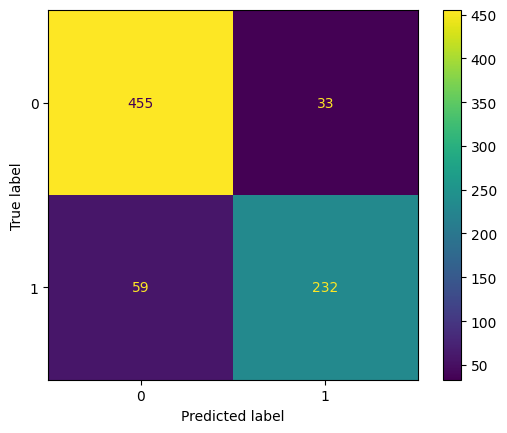

In [84]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test_stem, y_test)

### The Precision/Recall Trade-off

Increasing percision will decrease recall and vice-versa.

#### The Decision Function

The **SGDClassifier** will make its predictions by computing a score based on a *decision function*. If a score is greater than the threshold it will be assigned to the positive class and if not it will be assigned to the negative class. The default threshold for our model is 0. If we increase the threshold our precision will go up and the recall will go down. As a reminder before we do so, here is the current f1 score for our model.

In [85]:

from sklearn.metrics import f1_score

f1 = f1_score(y_test, predictions)
print(f1)

0.8345323741007195


In [86]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       488
           1       0.88      0.80      0.83       291

    accuracy                           0.88       779
   macro avg       0.88      0.86      0.87       779
weighted avg       0.88      0.88      0.88       779



Sklearn does not have a way for us to set this threshold but we can do so manually. First, we need to access the decision function. This will give us the score for a specific instance that was used to make its prediction.  Below we have the first 10 decision scores. There are 2 scores greater than 0 which symbolize the positive class predictions.

In [97]:
# scores 
y_scores = pipeline.decision_function(X_test_stem)
first_ten = y_scores[:10]
print(first_ten)

[-0.50768414 -0.25680371 -2.64511695 -0.74346657 -1.05569371  0.20140269
  0.62701504  1.45634152 -0.22600556 -1.5180115 ]


In [100]:
# decision scores are by default based on a 0 threshold, 2 positive cases predicted
threshold = 0
y_some_review_pred = (first_ten > threshold)
print(y_some_review_pred)

[False False False False False  True  True  True False False]


In [102]:
# positive predictions
pos_preds = y_scores[y_scores > threshold]
pos_preds[:10]

array([0.20140269, 0.62701504, 1.45634152, 0.60247909, 0.38185554,
       0.15418691, 1.22964798, 0.15728971, 1.47136241, 1.2421729 ])

In [106]:
pos_preds.min()

0.004312866736419008

In [117]:
# Filter indices of scores greater than the threshold
filtered_indices = np.where(y_scores > threshold)[0]

filtered_reviews = df.loc[filtered_indices, ['cleaned', 'recommended']]

In [118]:
filtered_reviews.head()

,cleaned,recommended
5,We flew in November 2023 but it took this long...,0
6,I left for London from Johannesburg at 2115 on...,0
7,After an excellent flight on a 777 CPT to LHR ...,0
10,This was the first time I flew British Airways...,0
12,Check in was fine but no priority fast track l...,1


In [112]:
for review, rating in filtered_reviews:
    print(f'{review}....{rating}\n')

ValueError: too many values to unpack (expected 2)

In [98]:
# raise the threshold
threshold = 5
y_bigger_threshold = (first_ten > threshold)

Now they are all False, or in our case, classified as negative reviews. This will of course reduce recall since we will have fewer false positives. This makes the model more strict about classifying a sample as a positive review. This also reduces recall since we will have mroe false negatives. 

In [99]:
print(y_bigger_threshold)

[False False False False False False False False False False]
